# Investigating Machine Learning Models Performance for Interpolation of Meterological Data
### Eli Simic Robertson
### Sentient Hubs Internship Short Project

In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
# add tftimeseries.py file path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'MastersDissertation', 'nbs', 'glassnode')))
from tftimeseries import *

%matplotlib inline

RESPONSE_VAR = 'temperature'
WINDOW_SIZE = 7
CONV_WIDTH = 3

In [221]:
df_temp = pd.read_csv('./hourly_weather_kaggle/temperature.csv')
df_humid = pd.read_csv('./hourly_weather_kaggle/humidity.csv')
df_press = pd.read_csv('./hourly_weather_kaggle/pressure.csv')
df_wind_d = pd.read_csv('./hourly_weather_kaggle/wind_direction.csv')
df_wind_s = pd.read_csv('./hourly_weather_kaggle/wind_speed.csv')

# Make dataframe for all Los Angeles weather continuous data features
df = df_temp[['datetime', 'Los Angeles']].rename(columns={'Los Angeles': 'temperature'})

df = df.merge(df_humid[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'humidity'}))
df = df.merge(df_press[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'pressure'}))
df = df.merge(df_wind_d[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_d'}))
df = df.merge(df_wind_s[['datetime','Los Angeles']].rename(columns={'Los Angeles': 'wind_s'}))


df['datetime'] = pd.to_datetime(df['datetime'])

df.head(5)

,datetime,temperature,humidity,pressure,wind_d,wind_s
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN
1,2012-10-01 13:00:00,291.870000,88.0,1013.0,0.0,0.0
2,2012-10-01 14:00:00,291.868186,88.0,1013.0,0.0,0.0
3,2012-10-01 15:00:00,291.862844,88.0,1013.0,0.0,0.0
4,2012-10-01 16:00:00,291.857503,88.0,1013.0,0.0,0.0


In [222]:
df.shape

(45253, 6)

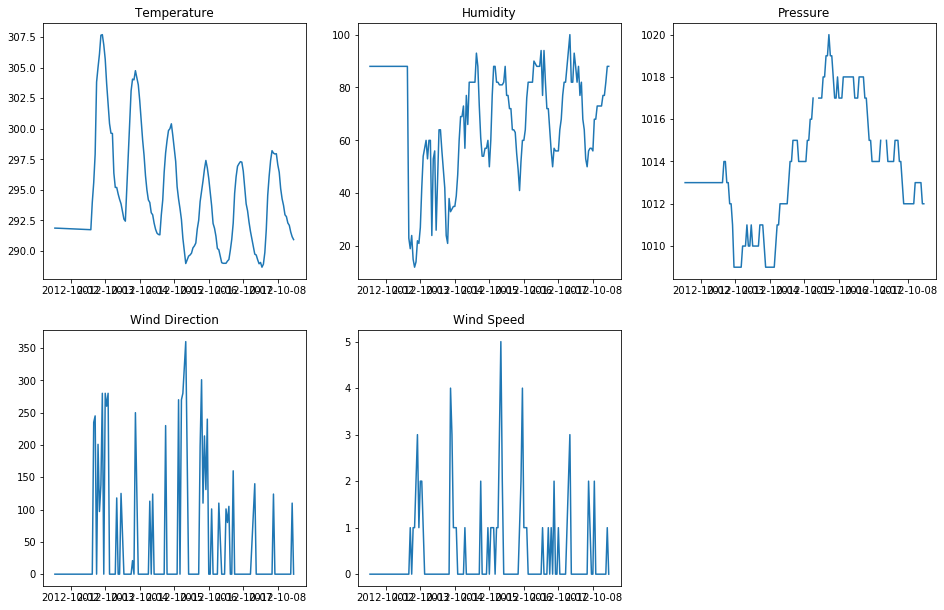

In [223]:
week = 24 * 7
df_1w = df.iloc[:week, :]

plt.figure(figsize=(16, 16))
plt.subplot(331)
plt.plot(df_1w['datetime'], df_1w['temperature'])
plt.title('Temperature')
plt.subplot(332)
plt.plot(df_1w['datetime'], df_1w['humidity'])
plt.title('Humidity')
plt.subplot(333)
plt.plot(df_1w['datetime'], df_1w['pressure'])
plt.title('Pressure')
plt.subplot(334)
plt.plot(df_1w['datetime'], df_1w['wind_d'])
plt.title('Wind Direction')
plt.subplot(335)
plt.plot(df_1w['datetime'], df_1w['wind_s'])
plt.title('Wind Speed');

In [224]:
df.isna().sum()

datetime         0
temperature      3
humidity       152
pressure       252
wind_d           1
wind_s           1
dtype: int64

In [225]:
252 / df.shape[0]

0.0055686915784588864

In [226]:
df = df.interpolate(method='linear').dropna()
df.isna().sum().sum()

0

#### Feature Engineering

In [227]:
# Source: https://www.tensorflow.org/tutorials/structured_data/time_series

wv = df.pop('wind_s')
# Convert to radians.
wd_rad = df.pop('wind_d')*np.pi / 180

# Calculate the wind x and y components.
df['wind_x'] = wv*np.cos(wd_rad)
df['wind_y'] = wv*np.sin(wd_rad)

#### Methodology 
- Create artificially noisy dataset
- Benchmark conventional interpolation techniques
- Train various Machine Learning models on Weather data to predict **Temperature**.
- Compare Model Predictions with Test dataset.
- Benchmark ML models performances against conventional interpolation techniques.

## Create Artificially Noisy Dataset
- Create 10% missing temperature data.

In [228]:
# Convert date col to numeric representation.

datetimes = df['datetime']

df = date_periodicity(df, date_col='datetime')

# Create Reference Dataframes 
train_df_ref, val_df_ref, test_df_ref = split_df(df)
# Throw out Train and Validation. We will create them later
_, _, test_df_ref, scaler = scale_datasets(train_df_ref, val_df_ref,
                                                   test_df_ref, y=None)


In [229]:
def create_noisy_df(reference_df, gap_prob=gap_prob):
    """Create a Dataframe with artificially inserted gaps (in form of NaN) from a 'complete'
    Reference dataframe.
    
    Args:
        reference_df (pd.Dataframe): Complete Dataframe
        gap_prob (float): Percentage of Dataframe containing NaN.
        
    Returns:
        noisy_df (pd.Dataframe): Dataframe containing NaN values.
    """
    # generate a range of vals (0 ... n_rows)
    idxs = np.arange(reference_df.shape[0])
    # generate a sin wave onto range
    noisy_df_sin = np.sin(idxs) ** 2
    # use sum as denominator to make the sin vals total to 1.
    sum_idxs = np.sum(noisy_df_sin)

    prob = noisy_df_sin / sum_idxs
    # check the sum of sin's totals to 1.
    assert int(np.sum(prob)) == 1

    n_gaps = int(reference_df.shape[0] * gap_prob)
    # randomly choose gap indexes
    gap_indxs = np.random.choice(a=test_df.shape[0], size=n_gaps, replace=False, p=prob)
    
    noisy_df = reference_df.copy()

    noisy_df['temperature'].iloc[gap_indxs] = np.nan
    
    return noisy_df
    

In [230]:
sample_size = 100

gap_prob = 0.2

In [231]:
def plot_complete_and_gaps(complete_series, gap_series, 
                      gap_prob=gap_prob, sample_size=100):
    '''
        Inputs:
            complete_series: Series containing all values.
            gap_series: Series containing missing values due to artifical noise.
            gap_prob: Amount of noise imposed on Series(for plotting).
    '''
    
    
    # extract datetimes for df indexing
    test_datetimes =  datetimes[-test_df.shape[0]:]
    # Create df for easy plotting
    df_temp_all = pd.DataFrame({'Complete': complete_series,
                                'DataWithGaps': gap_series}).set_index(test_datetimes)

    # Create a indicator column for missing temperature value.
    df_temp_all['Missing'] = df_temp_all[df_temp_all['DataWithGaps'].isna()]['Complete']
    
    if np.isnan(df_temp_all['Missing']).all(): 
        df_temp_all = df_temp_all.drop(columns=['Missing'])
    
    styles=['k--', 'bo-', 'r*']
    
    start_index = np.random.randint(low=0, high=df_temp_all.shape[0]-sample_size)
    end_index = start_index + sample_size
    
    df_temp_all.iloc[start_index:end_index, :].plot(style=styles, figsize=(20,10));
    plt.title(f'Complete vs Gap Dataset Interpolated')
    plt.ylabel('Temperature');

### Creating Gap Dataframe from Complete Test Series

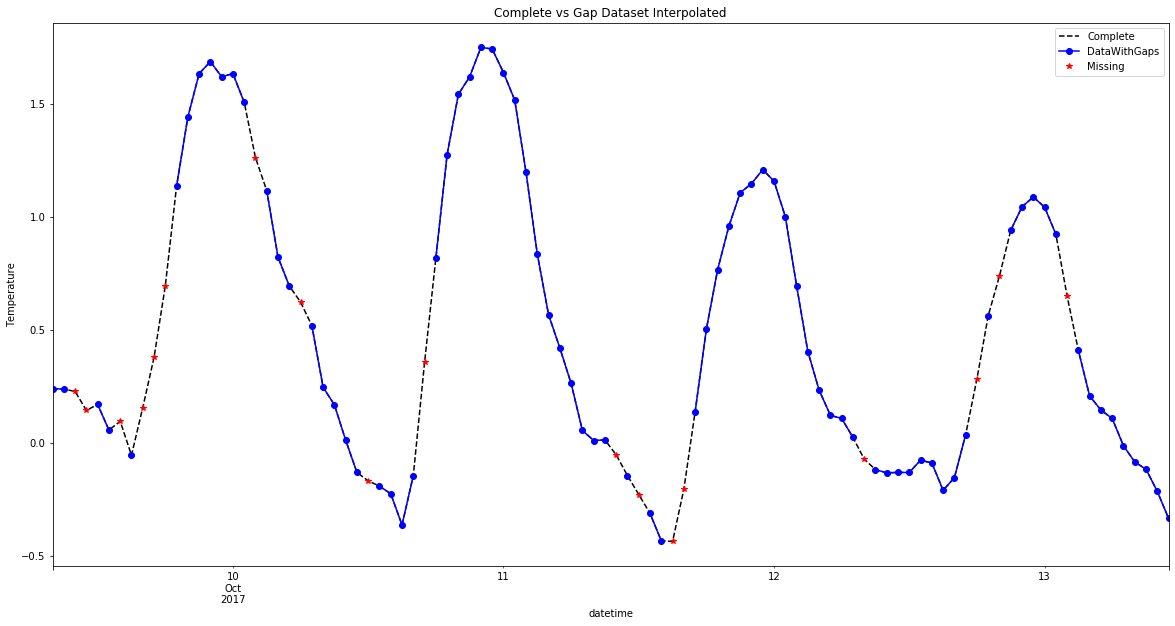

In [233]:
# Make Gap dataframe from Reference Test set (Complete Dataframe)
gap_test_df = create_noisy_df(test_df_ref, gap_prob=gap_prob)

plot_complete_and_gaps(test_df['temperature'], gap_test_df[RESPONSE_VAR])

#### Benchmarking Conventional Methods

In [234]:
methods = ['linear', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline',
           'polynomial', 'piecewise_polynomial', 'spline', 'pchip', 'akima',
      'cubicspline', 'from_derivatives']

def benchmark_conventional_methods(noisy_df, methods):
    mses = []

    for method in methods:
        order = 2
        temp_int = noisy_df['temperature'].interpolate(method=method, order=order)
        # fill if method creates NA val
        temp_int = temp_int.fillna(method='bfill').fillna(method='ffill')
        mse = mean_squared_error(test_df['temperature'], temp_int)

        mses.append(mse)
        
    return pd.DataFrame({
        "method": methods,
        "MSE": mses}).sort_values(by='MSE',
                                  ascending=True).set_index(['method'])

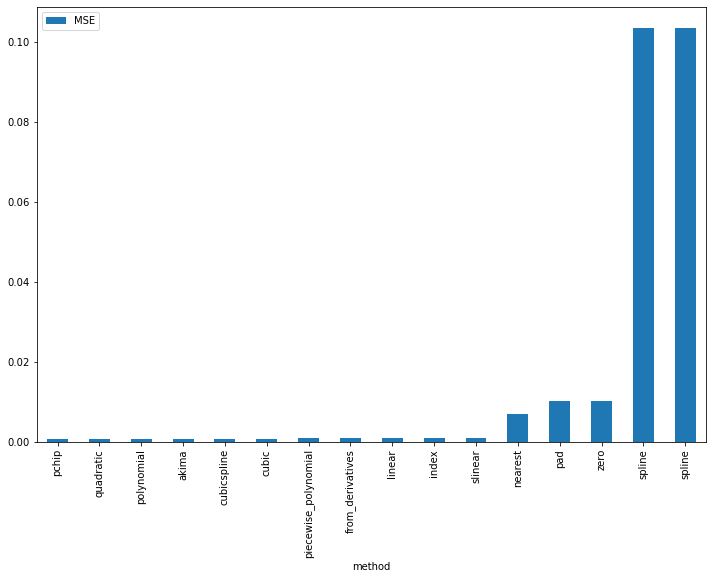

In [235]:
methods_df = benchmark_conventional_methods(gap_test_df, methods)

methods_df.plot(kind='bar', figsize=(12,8))

The interesting thing about this Interpolation problem is the conventional methods are aware of the next non-`NaN` point. However, the ML models are only aware of previous points.

#### Split and Scale 

In [236]:
train_df, val_df, test_df = split_df(df)
train_df, val_df, test_df, scaler = scale_datasets(train_df, val_df,
                                                   test_df, y=None)

## Linear Model

#### Windowing data

In [237]:
single_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

# window

In [238]:
single_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['temperature']

In [239]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(linear, single_window)

# Clear output from Ipython display after compiling.
clear_output()

### Convert Predictions into Interpolation Function
- find nans indexes 
- get preceeding 7 indexes for nan indexes, if index < 7 => interpolate with conventional method
- feed 7 size window to model
- merge prediction into noisy dataframe

In [240]:
def model_interpolate(model, window, gap_test_df, window_size=WINDOW_SIZE, 
                      conv_model=False, gap_size=1):
    """Interpolate a noisy column using a Tensorflow model predictions.
    
    Args:
        model: Tensorflow model.
        window: Window object.
        gap_test_df (pd.Dataframe): Dataframe containing noise (NaN)
        window_size: if `conv_model=False`, size of input_window
        conv_model (bool): Type of model and window.
        
    Returns:
        noisy_test_array (np.array): A numpy array containing original data 
            and interpolated predictions.
    """
    
    gap_test_df_copy = gap_test_df.copy()
    # Interpolate the first n-window-size to enable further interpolation.
    gap_test_df_copy.iloc[:window.total_window_size] = gap_test_df_copy.iloc[:window.total_window_size].interpolate(method='akima')
    noisy_test_array = gap_test_df_copy[RESPONSE_VAR].to_numpy()
    
    # Get indexes of nan values, index to 0th dimension (ugly)
    nan_indxs = np.where(np.isnan(noisy_test_array))[0]
    
    count=0
    for nan_indx in nan_indxs:        
        window_instance = window.make_dataset(window.test_df[nan_indx - window.total_window_size: nan_indx])
        
        # Make a prediction for the NaN
        preds = model.predict(window_instance)
        
        # Extract last pred from the second dimension of the Tensor.
        last_pred_index = window.label_width - 1
        
        # FIX CLEAN UP
        if lstm:
            pred = preds[0,0]
        else:
            pred = preds[0,last_pred_index,0]

        # Interpolate point inplace of the NaN index.
        np.put(noisy_test_array, nan_indx, pred)
        
    return noisy_test_array

#### Tensorflow Linear Model Interpolation

In [242]:
interp_linear = model_interpolate(linear, single_window, gap_test_df)

NameError: name 'plot_complete_and_gap' is not defined

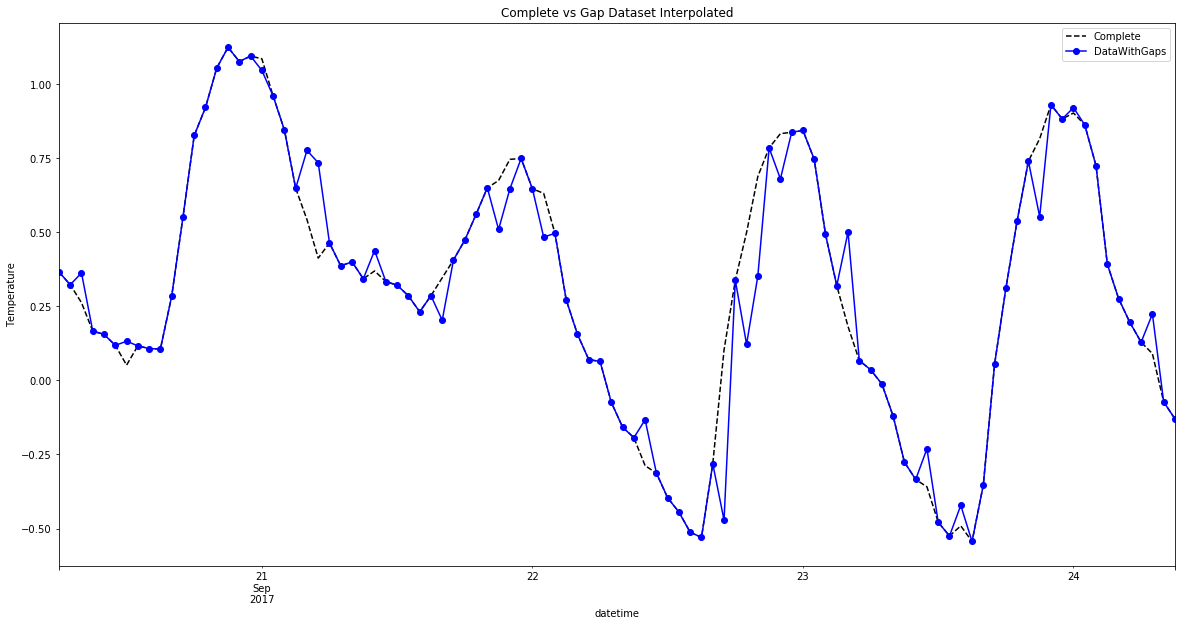

In [243]:
plot_complete_and_gaps(test_df[RESPONSE_VAR], interp_linear)

In [244]:
def score_interpolation(interpolated_array, test_array, metric=mean_squared_error):
    return metric(test_array, interpolated_array)

In [245]:
score_interpolation(interp_linear, test_df[RESPONSE_VAR])

0.022262125645120017

#### Convolutional Model

In [76]:
CONV_WINDOW_SIZE = WINDOW_SIZE - 2

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


conv_window = WindowGenerator(
    input_width=CONV_WINDOW_SIZE + (CONV_WIDTH - 1), label_width=CONV_WINDOW_SIZE, shift=1,
    label_columns=[RESPONSE_VAR],
    train_df=train_df,
    val_df=val_df,
    test_df=test_df)

compile_and_fit(conv_model, conv_window)
clear_output()

#### Convolutional Interpolation

In [247]:
interp_conv = model_interpolate(conv_model, conv_window, gap_test_df)

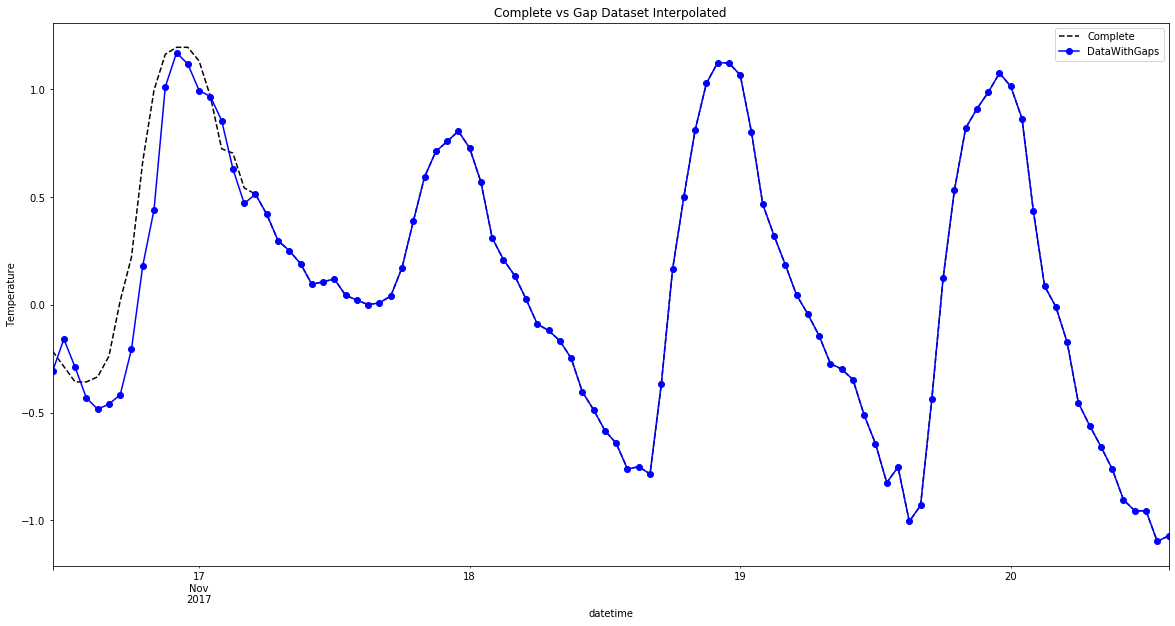

In [248]:
# This plots a random subset of data, so may not always include interpolation points.
plot_complete_and_gaps(test_df[RESPONSE_VAR], interp_conv)

In [78]:
score_interpolation(interp_conv, test_df['temperature'])

0.0127249286481005

### Make the Noise Longer

We can see the ML methods are performing terribly when compared to the conventional methods. This makes sense, as we can see that often the gaps in the data are quite linear in nature. To challenge the conventional methods more, we can create a noisy dataset, with larger intervals of ```NaN``` values.

###### Method
* Generate consecutive gaps in data ranging from 24-36 values in length (1-1.5 days)

In [256]:
def generate_gap_sequences_indices(n_gap_sequences, gap_size):
    """TODO: n_nans != sum of NaN in df.
    """
    gap_indices = []
    count = 0

    while (count < n_gap_sequences):
        # Generate a random slice indicies
        start_index = np.random.randint(low=0, high=test_df.shape[0] - gap_size)
        end_index = start_index + gap_size

        # If index in current gap indices, ignore to avoid longer sequences
        if start_index in gap_indices: 
            continue

        else:
            count += 1
            
            gap_i_range = list(np.arange(start_index, end_index))
            gap_indices.extend(gap_i_range)
            
    return gap_indices, count


gap_pct = 0.2
gap_size = 36


def set_gap_size_df(df, gap_pct, gap_size, response=RESPONSE_VAR):
    # Total amount of NaN values in df.
    n_nans = int(gap_pct * test_df.shape[0])
    n_gap_sequences = int(n_nans / gap_size)
    
    gap_indices, _ = generate_gap_sequences_indices(n_gap_sequences, gap_size)
    gap_df = df.copy()

    gap_df[response].iloc[gap_indices] = np.nan

    return gap_df    

In [261]:
gap2_df = set_gap_size_df(test_df, gap_pct=0.33, gap_size=150)

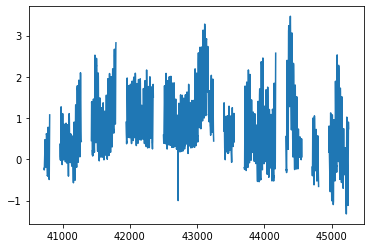

In [262]:
gap2_df[RESPONSE_VAR].plot()

In [263]:
methods_gap2_df = benchmark_conventional_methods(gap2_df, methods)

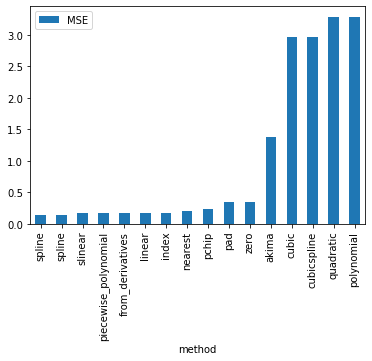

In [264]:
methods_gap2_df.plot(kind='bar')

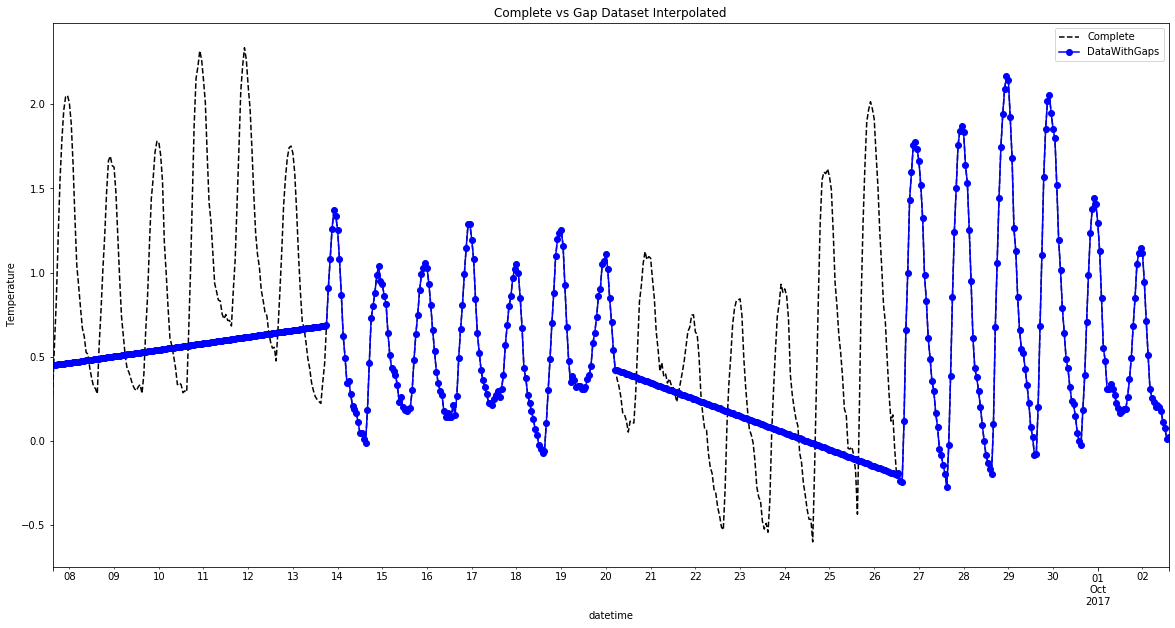

In [296]:
spline_interp = gap2_df.interpolate(method='piecewise_polynomial', order=3)
plot_complete_and_gaps(test_df[RESPONSE_VAR], spline_interp[RESPONSE_VAR], sample_size=600)

In [290]:
score_interpolation(spline_interp[RESPONSE_VAR], test_df[RESPONSE_VAR])

0.12713623848551076

#### When does the Spline break?

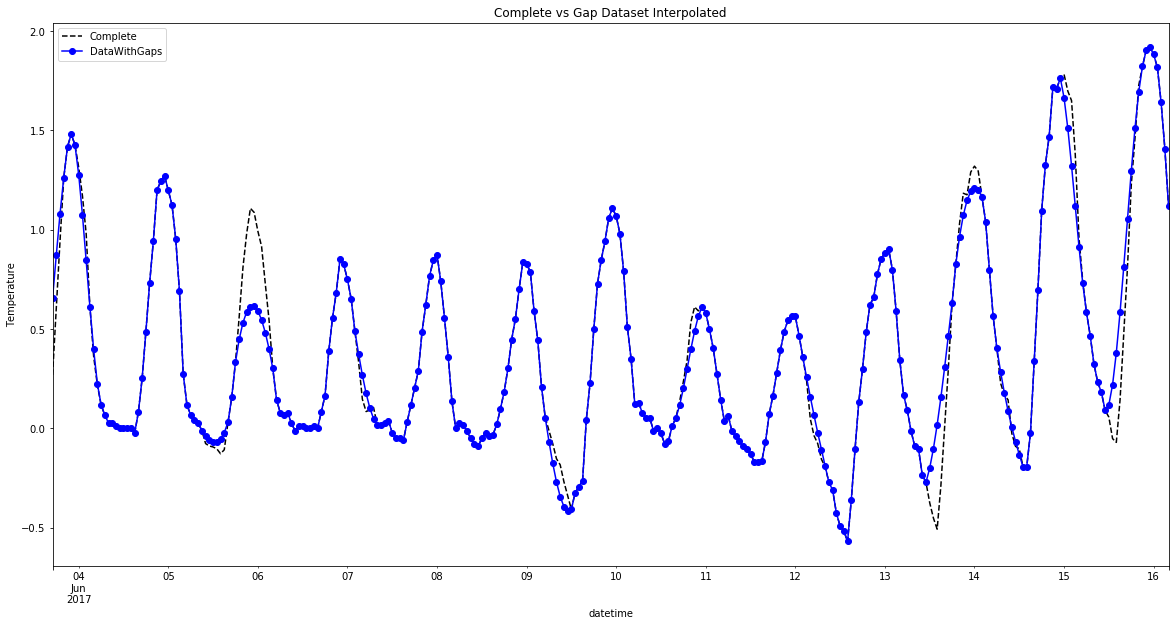

In [307]:
gap_test_df = set_gap_size_df(test_df, gap_pct=0.33, gap_size=6)

spline_interp_test = gap_test_df.interpolate(method='akima')

plot_complete_and_gaps(test_df[RESPONSE_VAR], spline_interp_test[RESPONSE_VAR], sample_size=300)

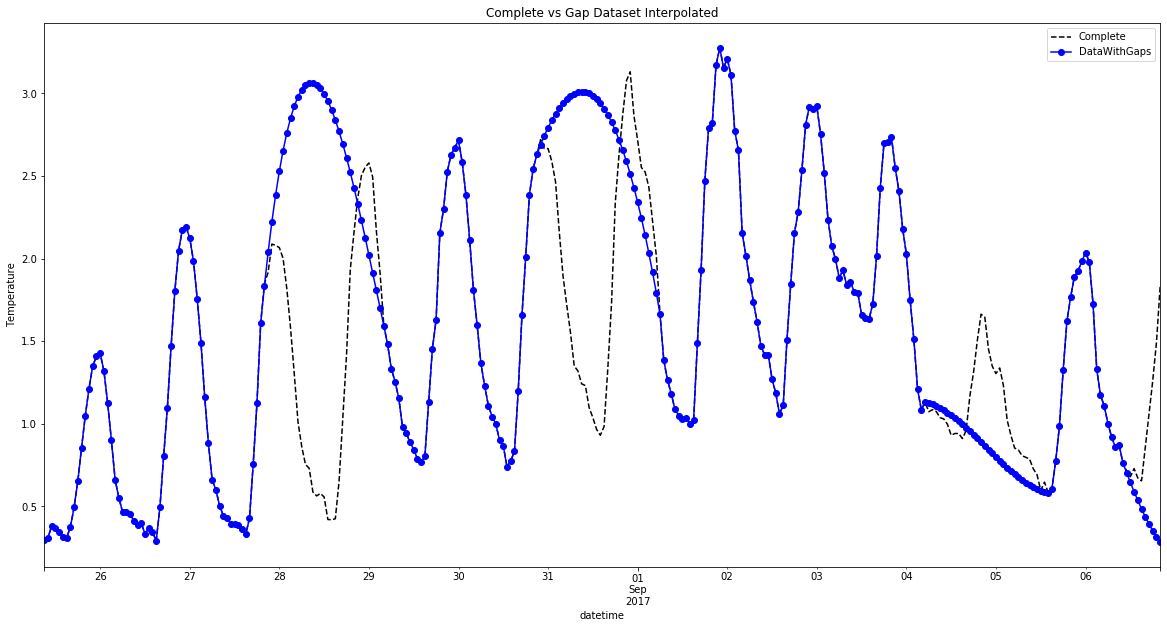

In [308]:
gap_test_df = set_gap_size_df(test_df, gap_pct=0.33, gap_size=32)

spline_interp_test = gap_test_df.interpolate(method='akima')

plot_complete_and_gaps(test_df[RESPONSE_VAR], spline_interp_test[RESPONSE_VAR], sample_size=300)

### Linear Inteprolation Gap Method 2

In [291]:
interp2_linear = model_interpolate(linear, single_window, noisy2_test_df)

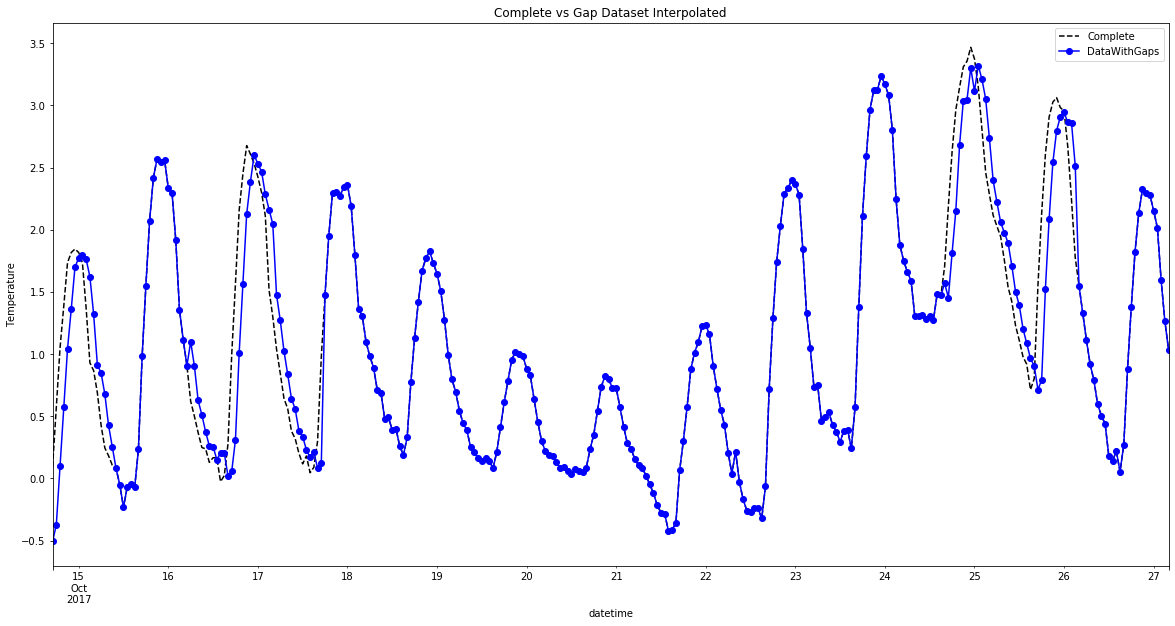

In [310]:
plot_complete_and_gaps(test_df[RESPONSE_VAR], interp2_linear, sample_size=300)

In [311]:
score_interpolation(interp2_linear, test_df[RESPONSE_VAR])

0.0236039856755628

### Convolutional Inteprolation Gap Method 2

In [312]:
interp_conv = model_interpolate(conv_model, conv_window, noisy2_test_df)

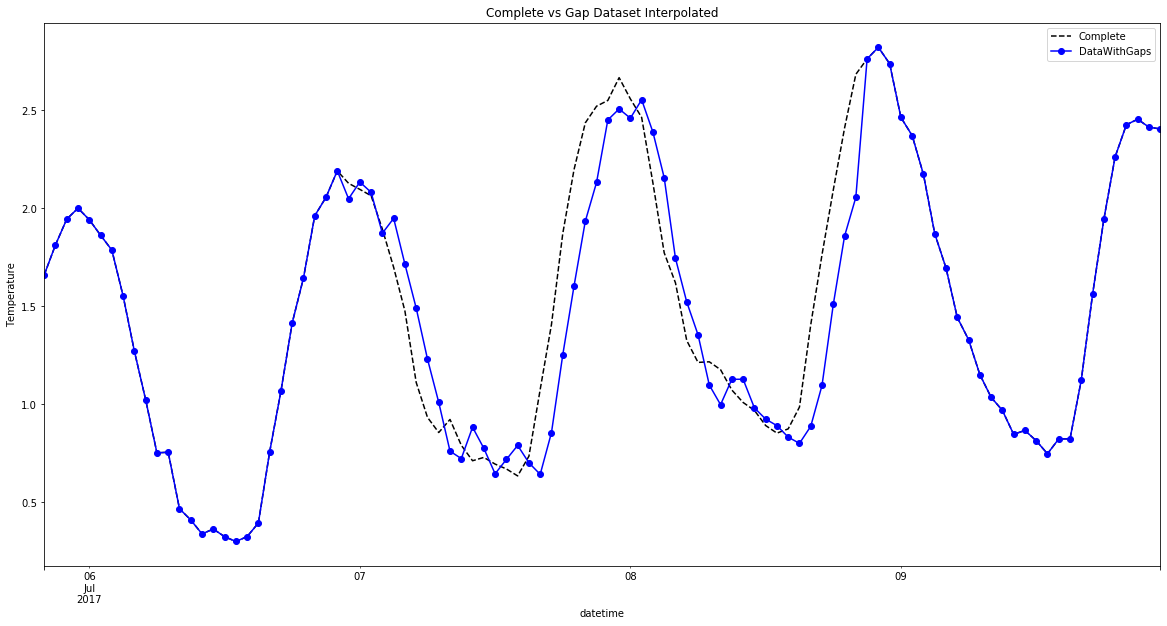

In [314]:
plot_complete_and_gaps(test_df[RESPONSE_VAR], interp_conv)

In [316]:
score_interpolation(interp_conv, test_df[RESPONSE_VAR])

0.014331558093599968

### LSTM

In [318]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(6, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


compile_and_fit(lstm_model, single_window)

clear_output()

Epoch 1/20
990/990 [==============================] - 5s 4ms/step - loss: 0.3846 - mean_absolute_error: 0.4347 - mean_absolute_percentage_error: 334.3503 - val_loss: 0.1943 - val_mean_absolute_error: 0.3182 - val_mean_absolute_percentage_error: 275.0140
Epoch 2/20
990/990 [==============================] - 3s 3ms/step - loss: 0.1348 - mean_absolute_error: 0.2699 - mean_absolute_percentage_error: 251.0417 - val_loss: 0.1443 - val_mean_absolute_error: 0.2718 - val_mean_absolute_percentage_error: 259.7823
Epoch 3/20
990/990 [==============================] - 3s 3ms/step - loss: 0.1273 - mean_absolute_error: 0.2615 - mean_absolute_percentage_error: 246.4701 - val_loss: 0.1351 - val_mean_absolute_error: 0.2608 - val_mean_absolute_percentage_error: 259.2923
Epoch 4/20
990/990 [==============================] - 3s 3ms/step - loss: 0.1253 - mean_absolute_error: 0.2588 - mean_absolute_percentage_error: 247.8541 - val_loss: 0.1309 - val_mean_absolute_error: 0.2543 - val_mean_absolute_percentage_

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

#### Bidirectional Wrapper around GRU's

In [337]:
from tensorflow.keras import regularizers

gru_bi = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, 
                        return_sequences=True,
                        kernel_regularizer=regularizers.l2(0.01))),
    tf.keras.layers.Dropout(0.66),
    tf.keras.layers.Dense(units=1)
])

compile_and_fit(gru_bi, conv_window)

clear_output()


In [343]:
def model_interpolate(model, window, gap_test_df, window_size=WINDOW_SIZE, 
                      conv_model=False, gap_size=1, lstm=False):
    """Interpolate a noisy column using a Tensorflow model predictions.
    
    Args:
        model: Tensorflow model.
        window: Window object.
        gap_test_df (pd.Dataframe): Dataframe containing noise (NaN)
        window_size: if `conv_model=False`, size of input_window
        conv_model (bool): Type of model and window.
        
    Returns:
        noisy_test_array (np.array): A numpy array containing original data 
            and interpolated predictions.
    """
    
    gap_test_df_copy = gap_test_df.copy()
    # Interpolate the first n-window-size to enable further interpolation.
    gap_test_df_copy.iloc[:window.total_window_size] = gap_test_df_copy.iloc[:window.total_window_size].interpolate(method='akima')
    noisy_test_array = gap_test_df_copy[RESPONSE_VAR].to_numpy()
    
    # Get indexes of nan values, index to 0th dimension (ugly)
    nan_indxs = np.where(np.isnan(noisy_test_array))[0]
    
    count=0
    for nan_indx in nan_indxs:        
        window_instance = window.make_dataset(window.test_df[nan_indx - window.total_window_size: nan_indx])
        
        # Make a prediction for the NaN
        preds = model.predict(window_instance)
        
        # Extract last pred from the second dimension of the Tensor.
        last_pred_index = window.label_width - 1
        
        pred = preds[0,last_pred_index,0]

        # Interpolate point inplace of the NaN index.
        np.put(noisy_test_array, nan_indx, pred)
        
    return noisy_test_array


interp_gru_bi = model_interpolate(gru_bi, conv_window, noisy2_test_df[:100], lstm=False)

In [339]:
score_interpolation(interp_gru_bi, test_df[RESPONSE_VAR])

0.08987146379167812

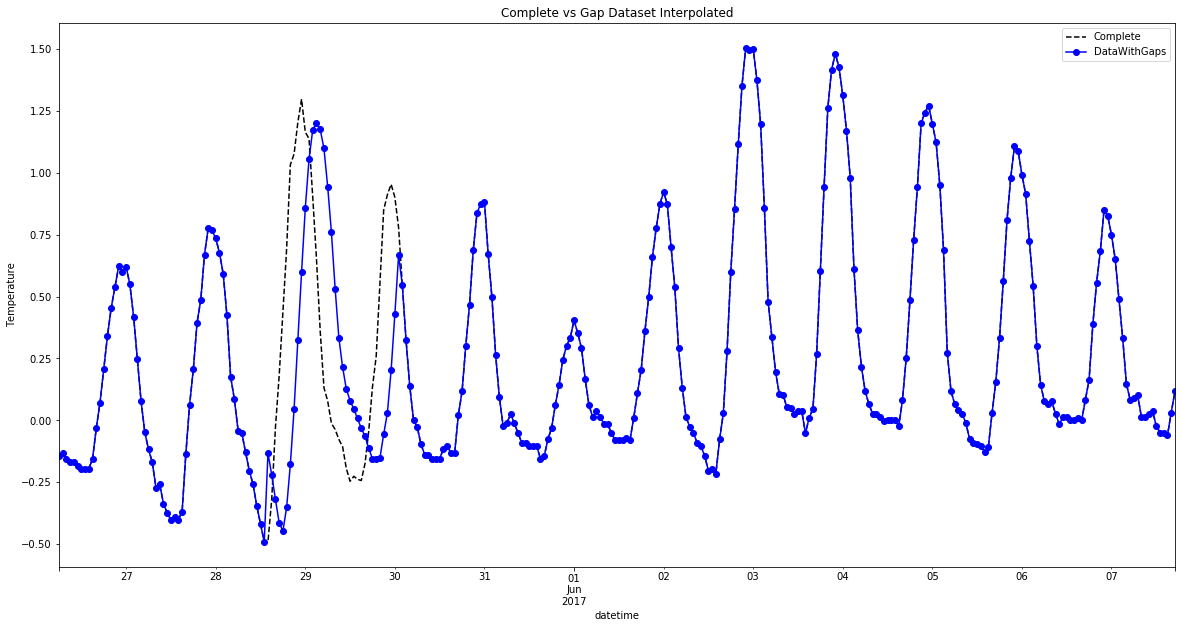

In [340]:
plot_complete_and_gaps(test_df[RESPONSE_VAR], interp_gru_bi, sample_size=300)